# Band Excitation data procesing

Code by: Marti Checa

Used in many different projects to analyze the regular adquisition of any type of Band Excitation Line mode data in the laboratory.

## Configure the notebook

In [1]:
# Make sure needed packages are installed and up-to-date
import sys
#!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py
#!{sys.executable} -m pip install -U --no-deps pycroscopy  # this will automatically install pyUSID as well

In [2]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os
import shutil
import math

# Computation:
import numpy as np
import h5py

# Visualization:
# import ipympl
import matplotlib.pyplot as plt
import matplotlib.widgets as mpw
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets

import pyUSID as usid
# Finally, pycroscopy itself
sys.path.append('..')
import pycroscopy as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [3]:
# set up notebook to show plots within the notebook
%matplotlib notebook

#adapt notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Set some basic parameters for computation
This notebook performs some functional fitting whose duration can be substantially decreased by using more memory and CPU cores. We have provided default values below but you may choose to change them if necessary.

In [4]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

## Make the data pycroscopy compatible
Converting the raw data into a pycroscopy compatible hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within pycroscopy

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

#### You can load either of the following:
* Any .mat or .txt parameter file from the original experiment
* A .h5 file generated from the raw data using pycroscopy - skips translation

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

In [5]:
input_file_path = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\BE_PFM_FunakuboPTO.h5'
#usid.io_utils.file_dialog(caption='Select translated .h5 file or raw experiment data',
                  #                        file_filter='Parameters for raw BE data (*.txt *.mat *xls *.xlsx);; \
                  #                        Translated file (*.h5)')
(data_dir, filename) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    force = True # Set this to true to force patching of the datafile.
    #tl = px.io.translators.LabViewH5Patcher()
    #tl.translate(h5_path, force_patch=force)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.io.translators.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.io.translators.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)

h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

Working on:
C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\BE_PFM_FunakuboPTO.h5


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


In [6]:
dir(filename)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [7]:
print('Datasets and datagroups within the file:\n------------------------------------')
usid.hdf_utils.print_tree(h5_file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)
print('\nThe ancillary datasets:\n------------------------------------')
print(h5_main.h5_pos_inds)
print(h5_main.h5_pos_vals)
print(h5_main.h5_spec_inds)
print(h5_main.h5_spec_vals)

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key, val in usid.hdf_utils.get_attributes(h5_main.parent.parent).items():
    print('{} : {}'.format(key, val))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_001
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices

The main dataset:
--------------------------------

## Get some basic parameters from the H5 file
This information will be vital for futher analysis and visualization of the data

In [8]:
h5_pos_inds = h5_main.h5_pos_inds
pos_dims = h5_main.pos_dim_sizes
pos_labels = h5_main.pos_dim_labels
print(pos_labels, pos_dims)

parm_dict = h5_main.parent.parent.attrs
is_ckpfm = h5_file.attrs['data_type'] == 'cKPFMData'
if is_ckpfm:
    num_write_steps = parm_dict['VS_num_DC_write_steps']
    num_read_steps = parm_dict['VS_num_read_steps']
    num_fields = 2

['X', 'Y'] [128, 128]


## Visualize the raw data
Use the sliders below to visualize spatial maps (2D only for now), and spectrograms.
For simplicity, all the spectroscopic dimensions such as frequency, excitation bias, cycle, field, etc. have been collapsed to a single slider.

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


<IPython.core.display.Javascript object>


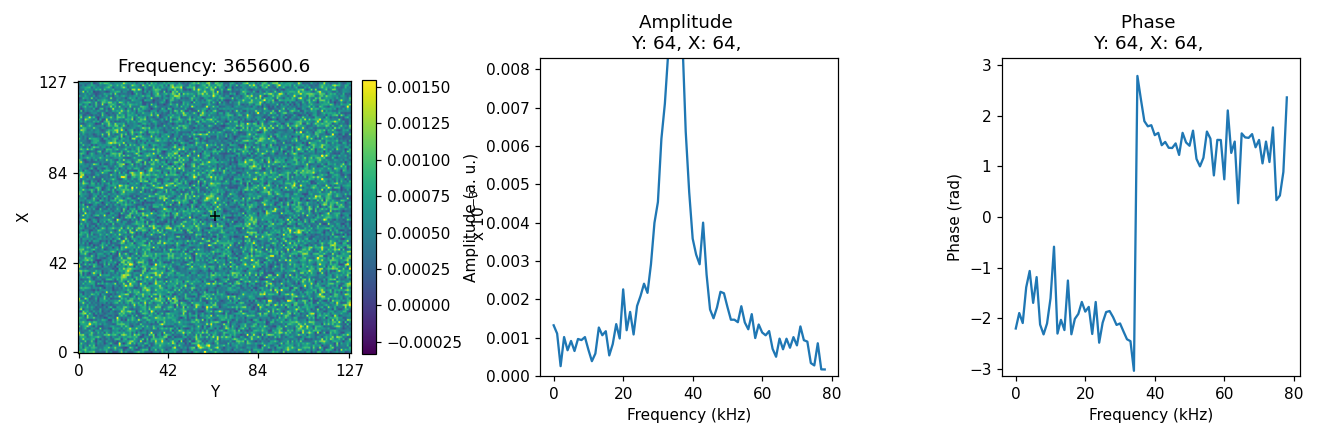

interactive(children=(IntSlider(value=0, description='Step', max=79), Output()), _dom_classes=('widget-interac…

In [9]:
fig = px.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

In [10]:
sho_fit_points = 5  # The number of data points at each step to use when fitting
sho_override = False  # Force recompute if True
sho_fitter = px.analysis.BESHOfitter(h5_main, verbose=False)
sho_fitter.set_up_guess()
h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', options={'num_points':sho_fit_points},
                                   processors=max_cores, max_mem=max_mem, override=sho_override)
sho_fitter.set_up_fit()
h5_sho_fit = sho_fitter.do_fit(processors=max_cores, max_mem=max_mem, override=sho_override)


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Group: <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (3 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (7 members)>]


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')



Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (7 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')



Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (7 members)>]


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Resuming computation. 87% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


In [11]:
h5_sho_fit

<HDF5 dataset "Fit": shape (16384, 1), type "|V20">
located at: 
	/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit 
Data contains: 
	SHO (compound) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	Single_Step - size: 1
Data Fields:
	Amplitude [V], Frequency [Hz], Quality Factor, Phase [rad], R2 Criterion

## Fast Data visualization

In [12]:
# We reshape the data:
h5_frequencies = usid.hdf_utils.find_dataset(h5_file, 'Bin_Frequencies')[0]
h5_reshaped = np.reshape(h5_main, (pos_dims[0], pos_dims[1],h5_frequencies.shape[0]))

In [15]:
%matplotlib inline

#Plot single lines spectra
line=40

spectra_amp=np.zeros((len(h5_frequencies),pos_dims[0]))
spectra_pha=np.zeros((len(h5_frequencies),pos_dims[0]))

for i in range(pos_dims[0]):
    spectra_amp[:,i]=np.absolute(h5_reshaped[line,i,:])
    spectra_pha[:,i]=np.angle(h5_reshaped[line,i,:])


#Plot single spectra
row_pos=40
col_pos=19
curve_Index=(pos_dims[0]*(row_pos))+(col_pos)

print("Pixel:")
print("X_pixel= "+str(col_pos))
print("Y_pixel= "+str(row_pos))
print("Curve Index= "+str(curve_Index))
print("Q= "+str(h5_sho_fit["Quality Factor"][curve_Index]))

#Here I define the function of the SHO fitter
def SHO_Amplitude_fit(w,A0,w0,Q):
    
                    return (A0*w0**2)/math.sqrt((w**2-w0**2)**2+((w*w0)/(Q))**2)

def SHO_Phase_fit(w,w0,Q):
    
                    return (math.atan((w*w0/Q)/((w**2)-(w0**2))))

A0=h5_sho_fit["Amplitude [V]"][curve_Index]
w0=h5_sho_fit["Frequency [Hz]"][curve_Index]
Q=h5_sho_fit["Quality Factor"][curve_Index]
vecSHO = np.vectorize(SHO_Amplitude_fit)
vecSHO_Ph = np.vectorize(SHO_Phase_fit)
w = np.arange(h5_frequencies[0],h5_frequencies[len(h5_frequencies)-1] , 10)
T = vecSHO(w,A0,w0,Q)
T2 = vecSHO_Ph(w,w0,Q)

Pixel:
X_pixel= 19
Y_pixel= 40
Curve Index= 5139
Q= [202.23337]


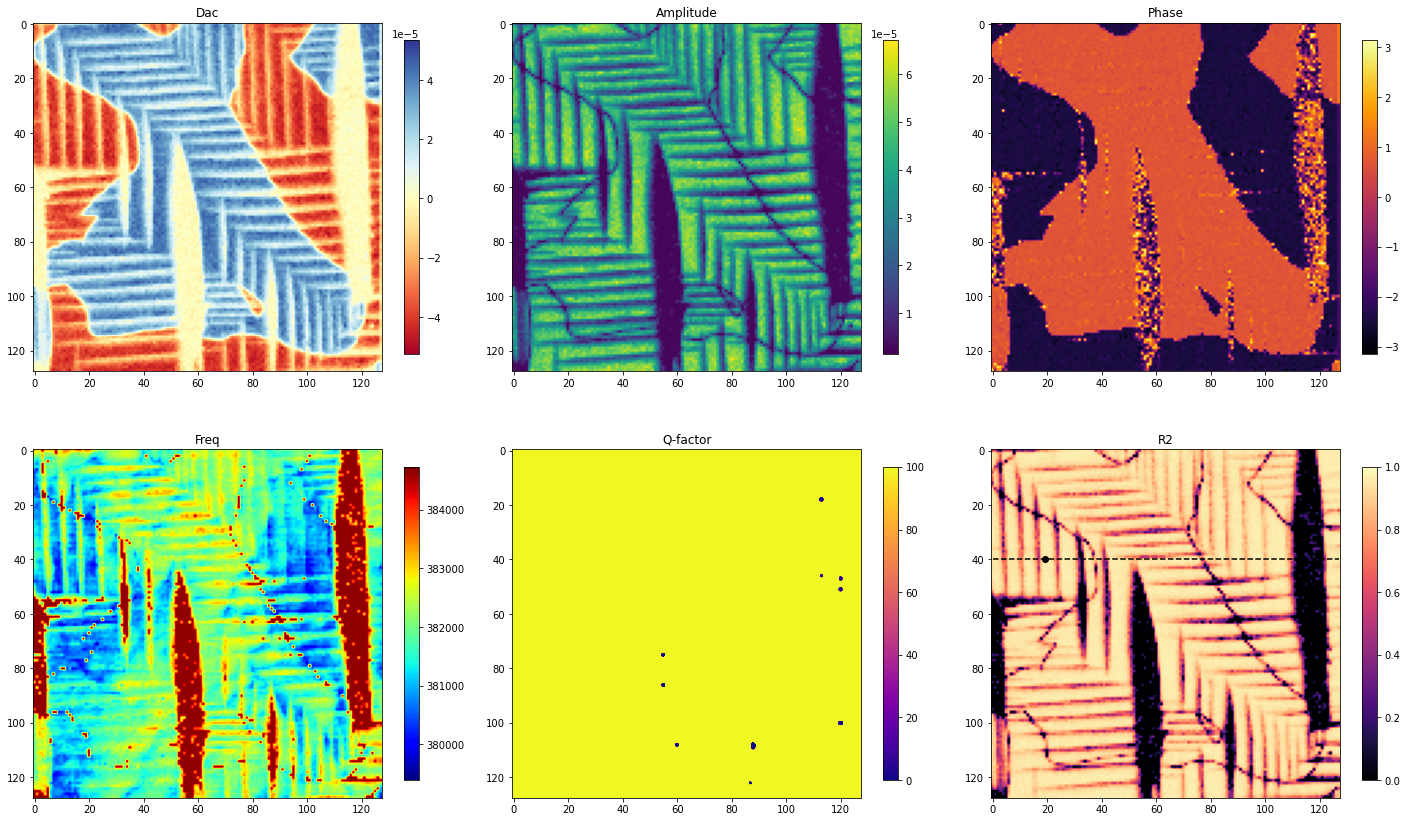

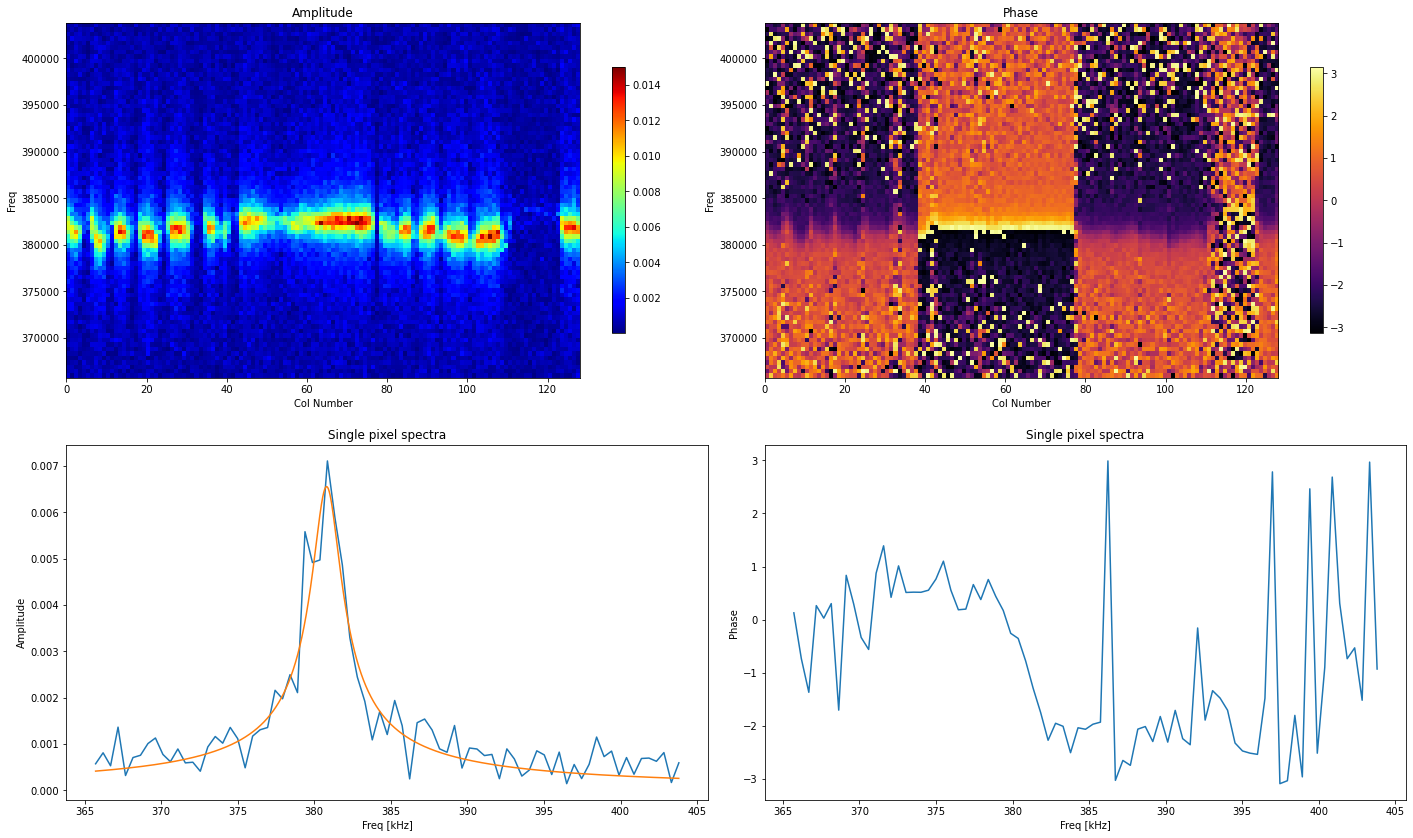

In [16]:
filename2 = filename[:-3]

os.chdir(r'C:\Users\3un\Documents\BE output')

Imagesize=pos_dims[0]

amp_mat= np.reshape(h5_sho_fit["Amplitude [V]"],(Imagesize,Imagesize))
np.savetxt(str(filename2)+"Amplitude.txt",amp_mat, delimiter = ",")

pha_mat= np.reshape(h5_sho_fit["Phase [rad]"],(Imagesize,Imagesize))
np.savetxt(str(filename2)+"Phase.txt",pha_mat, delimiter = ",")

freq_mat= np.reshape(h5_sho_fit["Frequency [Hz]"],(Imagesize,Imagesize))
np.savetxt(str(filename2)+"Frequency.txt",freq_mat, delimiter = ",")

Q_mat= np.reshape(h5_sho_fit["Quality Factor"],(Imagesize,Imagesize))
np.savetxt(str(filename2)+"Quality Factor.txt",Q_mat, delimiter = ",")

R2_mat= np.reshape(h5_sho_fit["R2 Criterion"],(Imagesize,Imagesize))
np.savetxt(str(filename2)+"R2 Criterion.txt",R2_mat, delimiter = ",")

mask_R2 = np.where(R2_mat > 0.2, 1, 0)
amp_secure=np.multiply(amp_mat,mask_R2)
pha_secure=np.multiply(pha_mat,mask_R2)

pha_offset=0
cos_mat=np.cos(pha_mat-pha_offset)
dac_mat=amp_mat*np.cos(pha_mat-pha_offset)

#uncomment for BE nanosurf data
dac_mat=np.fliplr(dac_mat)
amp_mat=np.fliplr(amp_mat)
pha_mat=np.fliplr(pha_mat)
freq_mat=np.fliplr(freq_mat)
Q_mat=np.fliplr(Q_mat)
R2_mat=np.fliplr(R2_mat)
spectra_pha=np.fliplr(spectra_pha)
spectra_amp=np.fliplr(spectra_amp)


#plt.hist(pha_mat-pha_offset)
#plt.show()

np.savetxt(str(filename2)+"pixe_spec_freq.txt",np.divide(h5_frequencies,1e3), delimiter = ",")
np.savetxt(str(filename2)+"pixe_spec_ampl.txt",np.absolute(h5_reshaped[row_pos,col_pos,:])*1e3, delimiter = ",")

np.savetxt(str(filename2)+"pixe_spec_freqfit.txt",w/1e3, delimiter = ",")
np.savetxt(str(filename2)+"pixe_spec_amplfit.txt",T*1e3, delimiter = ",")

np.savetxt(str(filename2)+"pixe_spec_pha.txt",np.angle(h5_reshaped[row_pos,col_pos,:]), delimiter = ",")


plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(2, 3)

gr1=axs[0, 0].imshow(dac_mat,cmap='RdYlBu')
axs[0, 0].title.set_text('Dac')
#axs[0,0].scatter(col_pos,row_pos,color='k')
#axs[0,0].plot(np.linspace(0,Imagesize-1,num=Imagesize),np.full((Imagesize,),line),'--k')
fig.colorbar(gr1,ax=axs[0, 0],shrink=0.75)

gr2=axs[0, 1].imshow(amp_mat,cmap='viridis')
axs[0, 1].title.set_text('Amplitude')
#axs[0,1].scatter(col_pos,row_pos,color='k')
#axs[0,1].plot(np.linspace(0,Imagesize-1,num=Imagesize),np.full((Imagesize,),line),'--k')
fig.colorbar(gr2,ax=axs[0, 1],shrink=0.75)

gr3=axs[0, 2].imshow(pha_mat,cmap='inferno')
axs[0, 2].title.set_text('Phase')
#axs[0,2].scatter(col_pos,row_pos,color='k')
#axs[0,2].plot(np.linspace(0,Imagesize-1,num=128),np.full((128,),line),'--k')
fig.colorbar(gr3,ax=axs[0, 2],shrink=0.75)

gr4=axs[1, 0].imshow(freq_mat, cmap='jet')
axs[1, 0].title.set_text('Freq')
#axs[1,0].scatter(col_pos,row_pos,color='k')
#axs[1,0].plot(np.linspace(0,Imagesize-1,num=128),np.full((128,),line),'--k')
fig.colorbar(gr4,ax=axs[1, 0],shrink=0.75)

#gr4=axs[1, 0].imshow(cos_mat,vmin=-1, vmax=1, cmap='bwr')
#axs[1, 0].title.set_text('Cos mat')
#axs[1,0].scatter(col_pos,row_pos,color='k')
#axs[1,0].plot(np.linspace(0,Imagesize-1,num=128),np.full((128,),line),'--k')
#fig.colorbar(gr4,ax=axs[1, 0],shrink=0.75)

gr5=axs[1, 1].imshow(Q_mat,vmin=0, vmax=100, cmap='plasma')
axs[1, 1].title.set_text('Q-factor')
#axs[1,1].scatter(col_pos,row_pos,color='k')
#axs[1,1].plot(np.linspace(0,Imagesize-1,num=128),np.full((128,),line),'--k')
fig.colorbar(gr5,ax=axs[1, 1],shrink=0.75)

gr6=axs[1, 2].imshow(R2_mat,vmin=0, vmax=1, cmap='magma')
axs[1, 2].title.set_text('R2')
axs[1,2].scatter(col_pos,row_pos,color='k')
axs[1,2].plot(np.linspace(0,Imagesize-1,num=128),np.full((128,),line),'--k')
fig.colorbar(gr6,ax=axs[1, 2],shrink=0.75)

fig.tight_layout(pad=1)

plt.rcParams['figure.figsize'] = [20, 12]
fig, axs = plt.subplots(2, 2)

gr1=axs[0, 0].imshow(np.flipud(spectra_amp),aspect='auto', cmap='jet',extent=[0,pos_dims[0],h5_frequencies[0],h5_frequencies[-1]])
axs[0, 0].title.set_text('Amplitude')
axs[0, 0].set(xlabel='Col Number', ylabel='Freq')
fig.colorbar(gr1,ax=axs[0, 0],shrink=0.75)

gr2=axs[0, 1].imshow(np.flipud(spectra_pha),aspect='auto',vmin=-np.pi, vmax=np.pi, cmap='inferno',extent=[0,pos_dims[0],h5_frequencies[0],h5_frequencies[-1]])
axs[0, 1].title.set_text('Phase')
axs[0, 1].set(xlabel='Col Number', ylabel='Freq')
fig.colorbar(gr2,ax=axs[0, 1],shrink=0.75)

gr3=axs[1, 0].plot(np.divide(h5_frequencies,1e3),np.absolute(h5_reshaped[row_pos,col_pos,:]))
gr3=axs[1, 0].plot(w/1e3, T, label='SHO fit')
axs[1, 0].title.set_text('Single pixel spectra')
axs[1, 0].set(xlabel='Freq [kHz]', ylabel='Amplitude')

gr4=axs[1, 1].plot(np.divide(h5_frequencies,1e3),np.angle(h5_reshaped[row_pos,col_pos,:]))
#gr3=axs[1, 1].plot(w/1e3, T2, label='SHO fit')
axs[1, 1].title.set_text('Single pixel spectra')
axs[1, 1].set(xlabel='Freq [kHz]', ylabel='Phase')

fig.tight_layout(pad=2)


## Save selected pixel data

In [17]:
os.chdir(r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\Saves images')
np.savetxt("Pixel_.txt",np.absolute(h5_reshaped[row_pos,col_pos,:]), delimiter = ",")
np.savetxt("Pixel_phase.txt",np.angle(h5_reshaped[row_pos,col_pos,:]), delimiter = ",")
np.savetxt("Freq_Pixel_.txt",np.divide(h5_frequencies,1e3), delimiter = ",")

## K-means clustering of the BE Line Data

Calculating the best k for the clustering...

12.5%
25.0%
37.5%
50.0%
62.5%
75.0%
87.5%

Optimal k is k=4



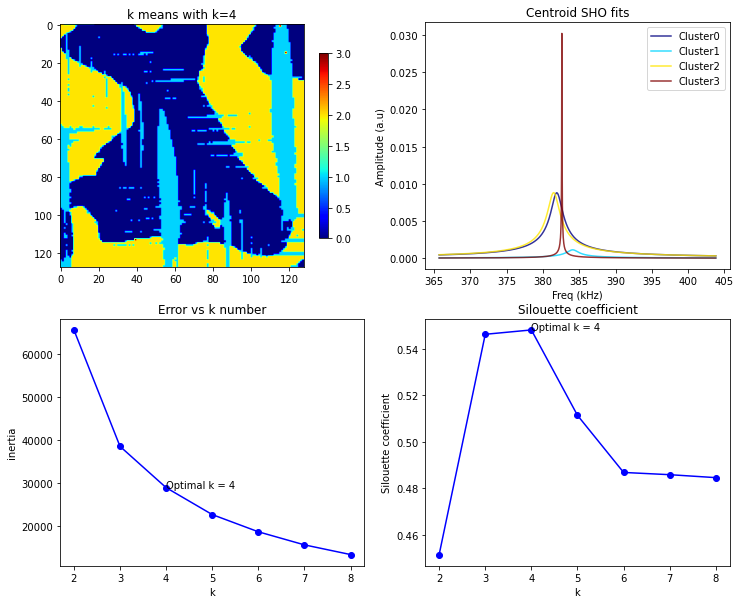

In [18]:
#Definition of Parameters

freq_map_vector=np.zeros(pos_dims[0]*pos_dims[1])
amp_map_vector=np.zeros(pos_dims[0]*pos_dims[1])
Q_map_vector=np.zeros(pos_dims[0]*pos_dims[1])
Phase_map_vector=np.zeros(pos_dims[0]*pos_dims[1])
dac_map_vector=np.zeros(pos_dims[0]*pos_dims[1])
r2_map_vector=np.zeros(pos_dims[0]*pos_dims[1])

#preparation of the data
for i in range(0,(pos_dims[0]*pos_dims[1])):
# We add the topo to each curve
    xid=math.trunc(i/pos_dims[0])
    yid=i-pos_dims[0]*math.trunc(i/pos_dims[0])    
#We fill the 1D vectors of the additional images
    freq_map_vector[i]=freq_mat[xid,yid]
    amp_map_vector[i]=amp_mat[xid,yid]
    Q_map_vector[i]=Q_mat[xid,yid]
    Phase_map_vector[i]=pha_mat[xid,yid]
    dac_map_vector[i]=dac_mat[xid,yid]
    r2_map_vector[i]=R2_mat[xid,yid]

freq_map_vector=freq_map_vector.reshape(-1, 1)
amp_map_vector=amp_map_vector.reshape(-1, 1)
Q_map_vector=Q_map_vector.reshape(-1, 1)
Phase_map_vector=Phase_map_vector.reshape(-1, 1)
dac_map_vector=dac_map_vector.reshape(-1, 1)
r2_map_vector=r2_map_vector.reshape(-1, 1)

#build the data and normalize it ready for k-means use...
data_for_kmeans=np.hstack((freq_map_vector,amp_map_vector,Q_map_vector,Phase_map_vector,dac_map_vector,r2_map_vector))
scaler = StandardScaler()
scaler.fit(data_for_kmeans)
Normalized_Data = scaler.transform(data_for_kmeans)

#Calculate the best k 
Number_of_k=8
K_number=np.linspace(2,Number_of_k,(Number_of_k-1))
error=np.empty((Number_of_k-1))
sil_coeff=np.empty((Number_of_k-1))

print('Calculating the best k for the clustering...')
print('')
for i in range(1,(Number_of_k)):
    print(str(i*100/Number_of_k)+'%')
    kmeans_error = KMeans(n_clusters=i+1, random_state=0).fit(Normalized_Data)
    error[i-1]=kmeans_error.inertia_
    sil_coeff[i-1] = silhouette_score(Normalized_Data, kmeans_error.labels_, metric='euclidean')

#we print the optimal k
print('')
print('Optimal k is k='+str(np.argmax(sil_coeff)+2))
print('')

# We now perform the k means algorithm with the optimal k
N=np.argmax(sil_coeff)+2
kmeans = KMeans(n_clusters=N, random_state=4, max_iter=2000, n_init=100).fit(Normalized_Data)
#Now I build the matrix with the different clusters:
labels=np.reshape(kmeans.labels_,(pos_dims[1],pos_dims[0]))
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

#Here I build the centroid SHO fits
w_domain=np.linspace(h5_frequencies[0],h5_frequencies[-1], num=1000)
SHO_func=np.vectorize(SHO_Amplitude_fit)

# Now I plot all the k-means clustering
ColorsA=plt.cm.jet(np.linspace(0, 1,N),alpha=0.8) #Equally spaced color 
ColorLabels=np.zeros((pos_dims[0]*pos_dims[1],N))

fig.tight_layout(pad=1)
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots(2, 2)

gr1=axs[0, 0].imshow(labels,cmap='jet')
fig.colorbar(gr1,ax=axs[0, 0],shrink=0.75)
axs[0, 0].title.set_text('k means with k='+str(N))

for i in range(0,N):
    gr2=axs[0, 1].plot(w_domain[:]/1000,SHO_func(w_domain[:],centroids[i,1],centroids[i,0],centroids[i,2]),label='Cluster'+str(i),c=ColorsA[i])
axs[0, 1].title.set_text('Centroid SHO fits')
axs[0, 1].set(xlabel='Freq (kHz)', ylabel='Amplitude (a.u)')
axs[0, 1].legend()

gr3=axs[1, 0].plot(K_number,error,'bo-')
axs[1, 0].title.set_text('Error vs k number')
axs[1,0].set(xlabel='k', ylabel='inertia')
axs[1,0].annotate('Optimal k = '+str(N), (N, error[N-2]))

gr4=axs[1, 1].plot(K_number,sil_coeff,'bo-')
axs[1, 1].title.set_text('Silouette coefficient')
axs[1,1].set(xlabel='k', ylabel='Silouette coefficient')
axs[1,1].annotate('Optimal k = '+str(N), (N, np.max(sil_coeff)))

plt.show()

## PCA Analysis of the BE line data

C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')
<ipython-input-19-f66710a0362e>:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq_vec = np.squeeze(h5_spec_vals.value) * 1E-3
C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Data currently of shape: (16384, 79)
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\io\usi_data.py:151: UserWarning: This dataset does not have an N-dimensional form
  warn('This dataset does not have an N-dimensional form')


Took 484.77 msec to compute randomized SVD


C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\viz\plot_utils.py:1257: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axes = ImageGrid(fig, 111, nrows_ncols=(p_rows, p_cols),
C:\ProgramData\Anaconda3\lib\site-packages\pyUSID\viz\plot_utils.py:1286: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = axes.cbar_axes[0].colorbar(im)
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\axes_grid1\axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor relea

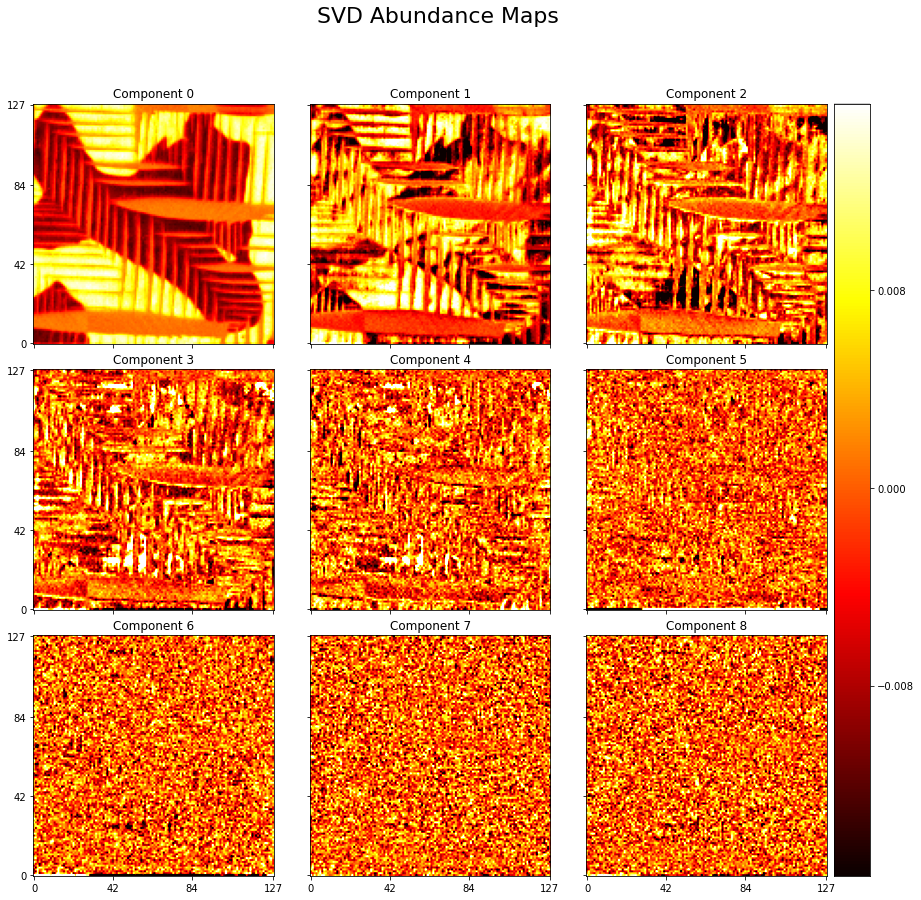

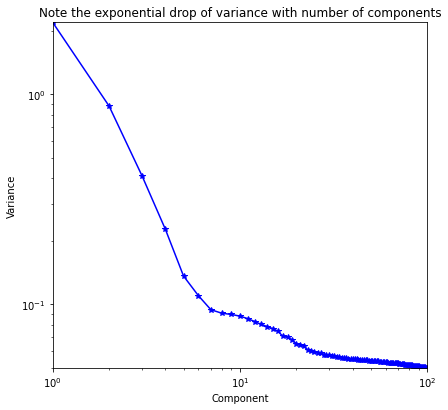

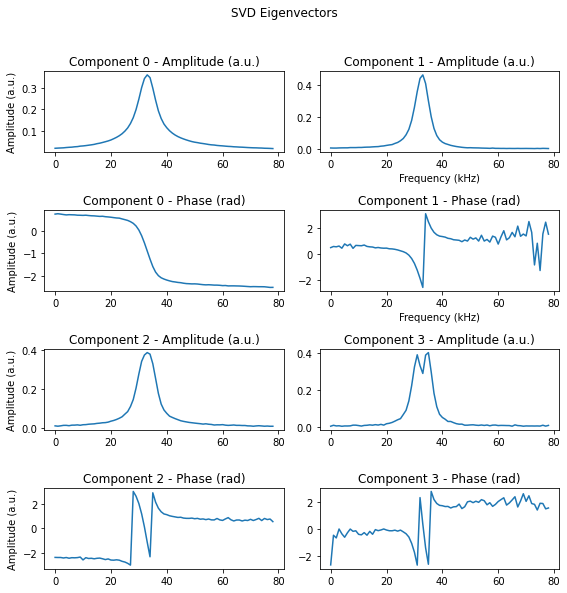

In [19]:
#Here I modify the script for the PCA Analysis of BE data (from the pycroscopy webpage:
# https://pycroscopy.github.io/pycroscopy/auto_examples/plot_spectral_unmixing.html)

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import subprocess
import sys
from pycroscopy.viz import cluster_utils

h5_meas_grp = h5_file['Measurement_000']

# Extracting some basic parameters:
num_rows = usid.hdf_utils.get_attr(h5_meas_grp, 'grid_num_rows')
num_cols = usid.hdf_utils.get_attr(h5_meas_grp, 'grid_num_cols')

# Getting a reference to the main dataset:
h5_main = usid.USIDataset(h5_meas_grp['Channel_000/Raw_Data'])
usid.hdf_utils.write_simple_attrs(h5_main, {'quantity': 'Deflection', 'units': 'V'})

# Extracting the X axis - vector of frequencies
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_main, 'Spectroscopic_Values')[-1]
freq_vec = np.squeeze(h5_spec_vals.value) * 1E-3

print('Data currently of shape:', h5_main.shape)

x_label = 'Frequency (kHz)'
y_label = 'Amplitude (a.u.)'

decomposer = px.processing.svd_utils.SVD(h5_main, num_components=100)
h5_svd_group = decomposer.test()

h5_u = h5_svd_group[0]
h5_v = h5_svd_group[2]
h5_s = h5_svd_group[1]

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:, :256], (num_rows, num_cols, -1))

usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='hot', title_yoffset=0.95)


# Visualize the variance / statistical importance of each component:
usid.plot_utils.plot_scree(h5_s, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
_ = usid.plot_utils.plot_complex_spectra(h5_v[:9, :], x_label=x_label, y_label=y_label,
                                       title='SVD Eigenvectors', evenly_spaced=False)

#Saving settings
#os.chdir(r'C:\Users\Martí\OneDrive\Escritorio\Analisis BE\PCA Analysis')
#np.savetxt("PCA_Comp_0.txt",abun_maps[:,:,0], delimiter = ",")
#np.savetxt("PCA_Comp_1.txt",abun_maps[:,:,1], delimiter = ",")
#np.savetxt("PCA_Comp_2.txt",abun_maps[:,:,2], delimiter = ",")
#np.savetxt("PCA_Comp_3.txt",abun_maps[:,:,3], delimiter = ",")

#np.savetxt("Eigenvectors.txt",h5_v[:9, :], delimiter = ",")


## Save PCA Eigenvectors

In [20]:
np.savetxt("Eigenvectors.txt",np.absolute(h5_v[:9, :]), delimiter = ",")

## Close h5 File

In [21]:
h5_file.close()